In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
from pprint import pprint
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size

from IPython.html.widgets import FloatProgress
from IPython.display import display
from time import sleep

## Run a session of the SCML world (2020)

The SCML world (Supply Chain Management League) runs on top of `NegMAS`.

In this tutorial, you will test a run of this world.

Firstly, let's import everything from the SCML app

In [2]:
from scml.scml2020 import *

There are several ways to create an SCML world. One of the simplest is to use one of the class methods of the `SCML2020World` class. 


In [3]:
world = SCML2020World(**SCML2020World.generate(agent_types=[DecentralizingAgent], n_steps=20))

*If you want to just test your installation (and do not care whether you get an accurate indicator of agent performance), you can set the number of steps to a small value (e.g. n_steps=10).*

Now you can run this world simulation by just calling `run`. In this example, we explicitly call `step` repeatedly to update a progress bar.

In [4]:
f = FloatProgress(min=0, max=world.n_steps) # just for showing a progress bar
display(f) # display progress bar

# run the world updating the progress bar.
for i in range(world.n_steps):
    world.step()
    f.value=i+1

FloatProgress(value=0.0, max=20.0)

Let's see what happened in this run. Firstly, how many negotiations were conducted over time

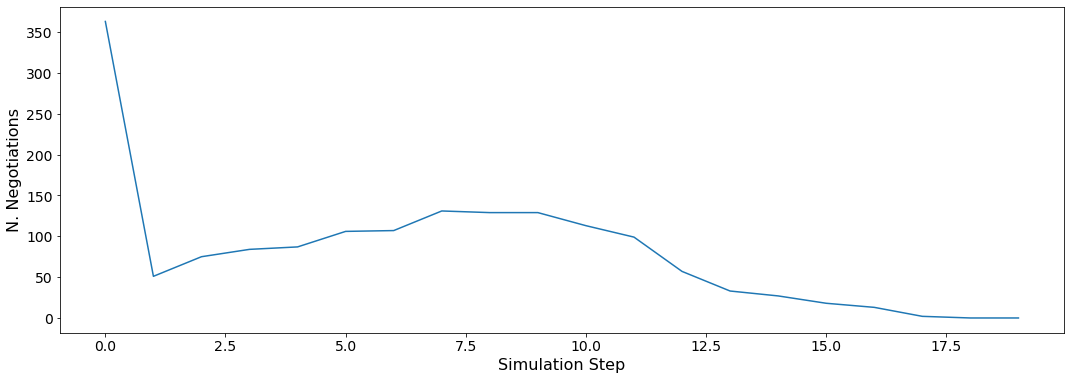

In [5]:
plt.plot(world.stats['n_negotiations'])
plt.xlabel('Simulation Step')
plt.ylabel('N. Negotiations')
plt.show()

It is clear that many negotiations happened at the beginning of the simulation with smaller number later. That is expected as the consumers publish their calls for proposals early on.

Several other market statistics are available:

In [6]:
pprint(list(_ for _ in world.stats.keys() if "@" not in _ and not _.startswith("_") ))

['n_registered_negotiations_before',
 'n_contracts_dropped',
 'n_contracts_executed',
 'n_contracts_erred',
 'n_contracts_nullified',
 'n_contracts_cancelled',
 'n_breaches',
 'breach_level',
 'n_contracts_signed',
 'n_contracts_concluded',
 'n_negotiations',
 'n_negotiation_rounds_successful',
 'n_negotiation_rounds_failed',
 'n_registered_negotiations_after',
 'activity_level',
 'n_contracts_nullified_now',
 'n_bankrupt',
 'trading_price_0',
 'real_quantity_0',
 'real_price_0',
 'trading_price_1',
 'real_quantity_1',
 'real_price_1',
 'trading_price_2',
 'real_quantity_2',
 'real_price_2',
 'trading_price_3',
 'real_quantity_3',
 'real_price_3',
 'trading_price_4',
 'real_quantity_4',
 'real_price_4',
 'productivity',
 'market_size',
 'production_failures',
 'bankruptcy']


We can for example check the activity level of this world (defined as the total amount of money transferred due to trade)

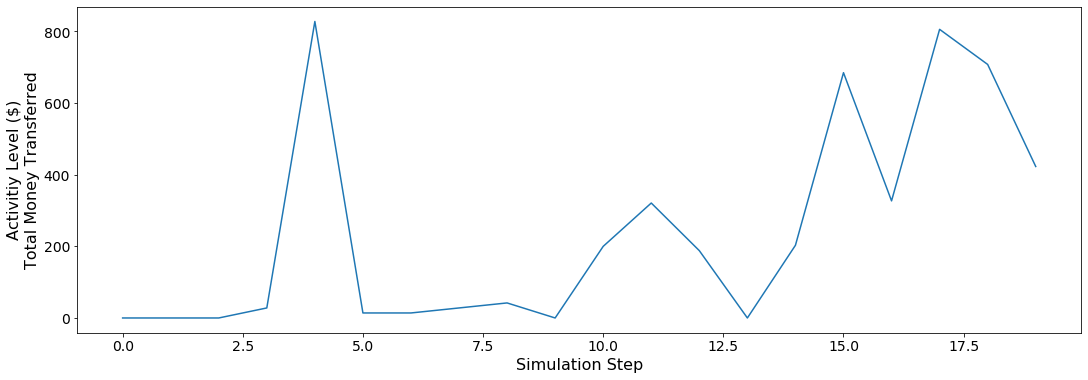

In [7]:
plt.plot(world.stats['activity_level'])
plt.xlabel('Simulation Step')
plt.ylabel('Activitiy Level ($)\nTotal Money Transferred')
plt.show()

We can see a picture of contracting in this world as follows:

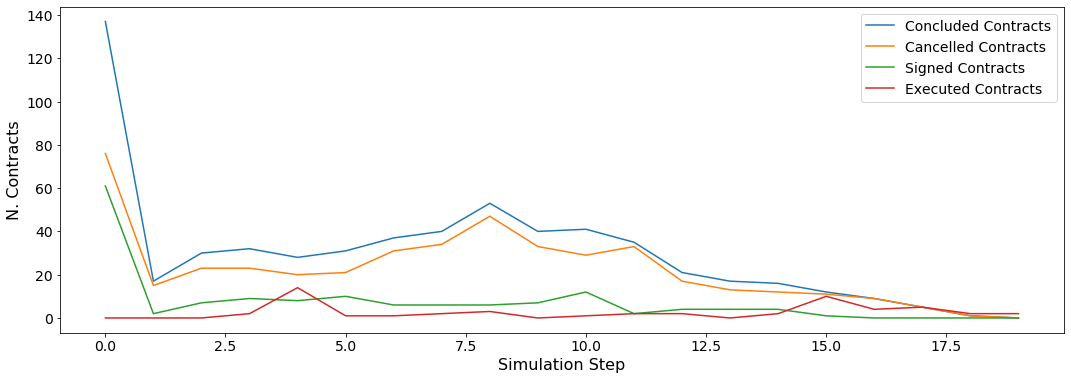

In [8]:
plt.plot(world.stats['n_contracts_concluded'], label='Concluded Contracts')
plt.plot(world.stats['n_contracts_cancelled'], label='Cancelled Contracts') 
plt.plot(world.stats['n_contracts_signed'], label='Signed Contracts') 
plt.plot(world.stats['n_contracts_executed'], label='Executed Contracts')
plt.legend()
plt.xlabel('Simulation Step')
plt.ylabel('N. Contracts')
plt.show()

We can also check the breaches that happened

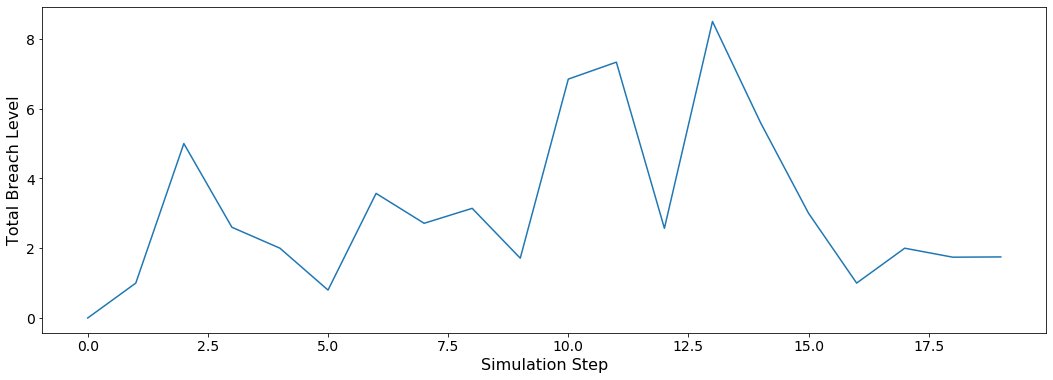

In [9]:
plt.plot(world.stats['breach_level'])
plt.xlabel('Simulation Step')
plt.ylabel('Total Breach Level')
plt.show()

It is also possible to focus on the behavior of some specific agent. Let's first find who was the winner (the factory manager that got maximum wealth). Notice that there can be multiple winners

In [10]:
winner_profits = [round(100.0 * world.stats[f'balance_{_}'][-1] / world.stats[f'balance_{_}'][0] - 100.0, 2) for _ in world.winners]
print(f"{world.winners} won at {winner_profits}%")

[07Dec@2] won at [1.3]%


What was the balance of this winner over time:

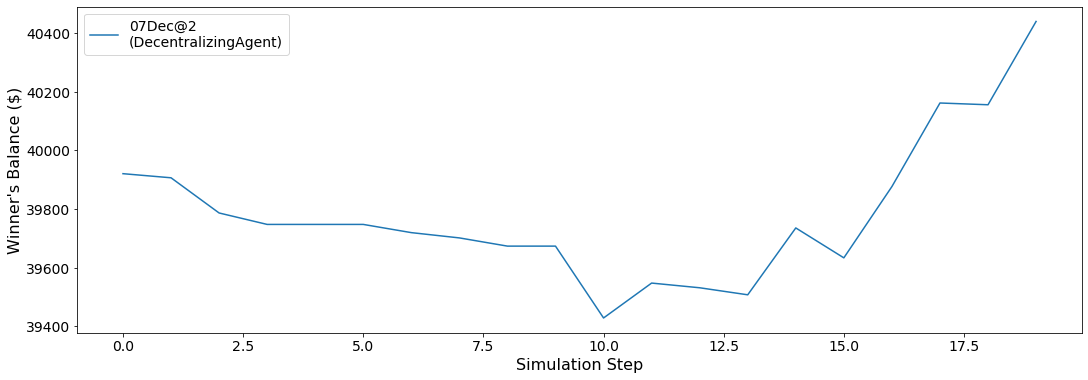

In [11]:
for winner in world.winners:
    plt.plot(world.stats[f'balance_{winner}'], label=f'{winner}\n({winner.__class__.__name__})')
plt.legend()
plt.xlabel('Simulation Step')
plt.ylabel('Winner\'s Balance ($)')
plt.show()

Let's check how did its total storage change over time:

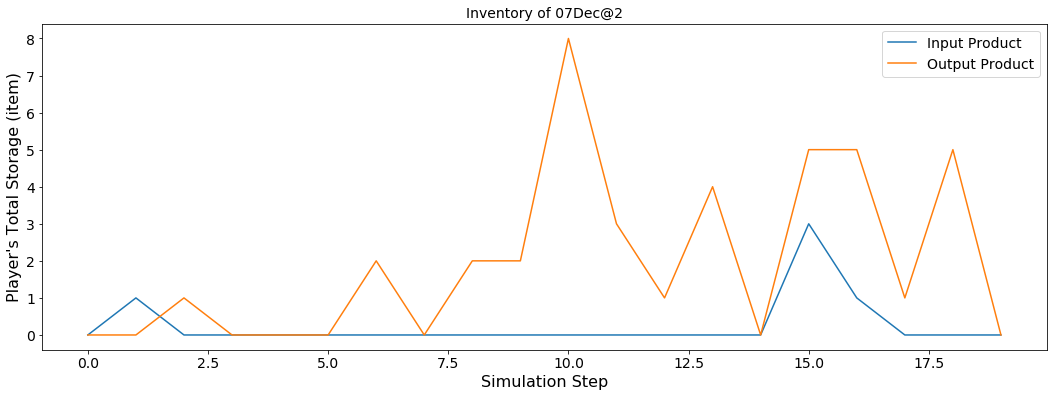

In [12]:
in_key = [_ for _ in world.stats.keys() if _.startswith(f'inventory_{winner}_input')][0]
out_key = [_ for _ in world.stats.keys() if _.startswith(f'inventory_{winner}_output')][0]
for winner in world.winners:
    plt.plot(world.stats[in_key], label=f"Input Product")
    plt.plot(world.stats[out_key], label=f"Output Product")
plt.xlabel('Simulation Step')
plt.ylabel('Player\'s Total Storage (item)')
plt.title(f"Inventory of {winner}")
plt.legend()
plt.show()

We can actually check what happens to ALL competitors:

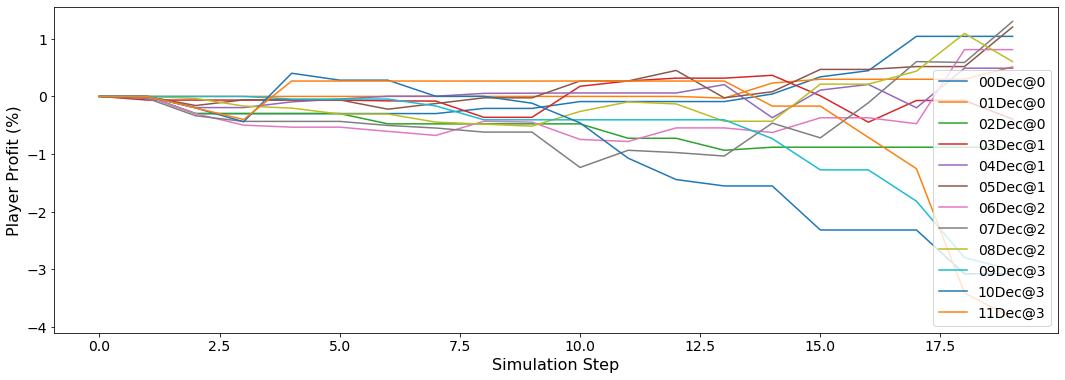

In [13]:
for name, _ in sorted(((_.name, _) for _ in world.agents.values() if _.name != "SYSTEM"), key=lambda x: x[0]):    
    plt.plot(100.0 * (np.asarray(world.stats[f'balance_{name}'])/world.stats[f'balance_{name}'][0] - 1.0), label=name)
plt.xlabel('Simulation Step')
plt.ylabel('Player Profit (%)')
plt.legend()
plt.show()

You can inspect what happened in the simulation by plotting different output statistics. For example, we can see how did the trading price of different products change over the simulation time.

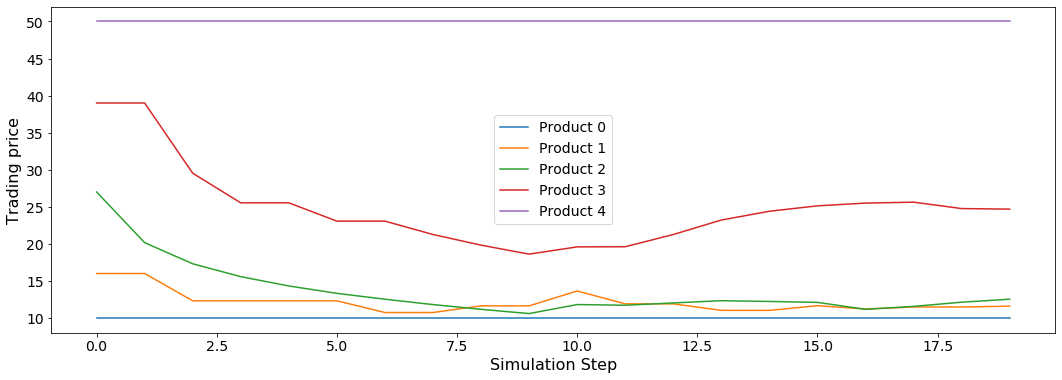

In [14]:
for p in range(world.n_products):
    plt.plot(world.stats[f"trading_price_{p}"], label=f"Product {p}")
plt.xlabel('Simulation Step')
plt.ylabel('Trading price')
plt.legend()
plt.show()

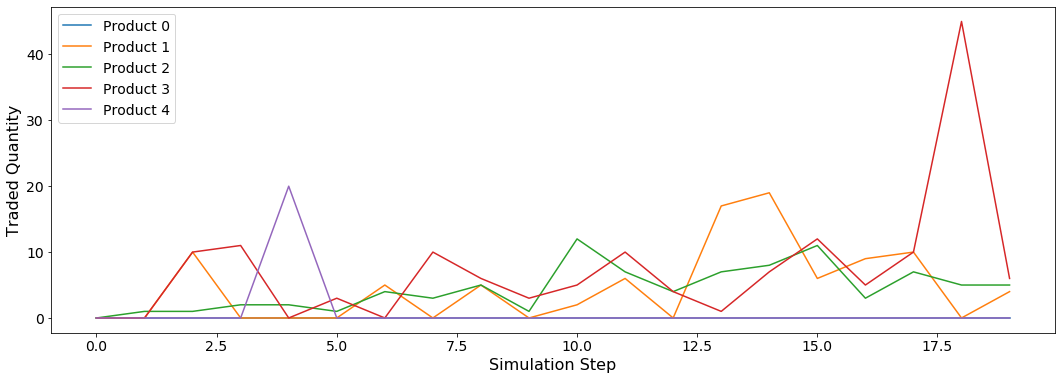

In [15]:
for p in range(world.n_products):
    plt.plot(world.stats[f"real_quantity_{p}"], label=f"Product {p}")
plt.xlabel('Simulation Step')
plt.ylabel('Traded Quantity')
plt.legend()
plt.show()